In [2]:
import numpy as np
import pandas as pd 
from keras.layers import Input, Lambda, Dense, Flatten , Dropout , MaxPool2D
from keras.models import Model , Sequential
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from glob import glob
import matplotlib.pyplot as plt
import random
import os
from distutils.file_util import copy_file
import warnings
warnings.filterwarnings('ignore')
from keras.callbacks import EarlyStopping ,ReduceLROnPlateau

In [3]:
train_dir='C:/Users/rupa/anaconda3/envs/FinalProject_AutoML/covid_Images/train_filtered/'
test_dir='C:/Users/rupa/anaconda3/envs/FinalProject_AutoML/covid_Images/test_filtered/'
train_data_gen = ImageDataGenerator(rescale=1./255 ,
                                    zoom_range= 0.3, 
                                    horizontal_flip= True, 
                                    shear_range= 0.2,
                                    rotation_range = 30
                                    )

train = train_data_gen.flow_from_directory(directory= train_dir,
                                           class_mode = 'binary',
                                           batch_size=64,
                                           target_size=(224,224))
test_data_gen = ImageDataGenerator(rescale=1./255 )

test = test_data_gen.flow_from_directory(directory= test_dir , 
                                          target_size=(224,224), 
                                            class_mode = 'binary',
                                        shuffle=False,
                                        batch_size=64)

Found 2630 images belonging to 2 classes.
Found 1030 images belonging to 2 classes.


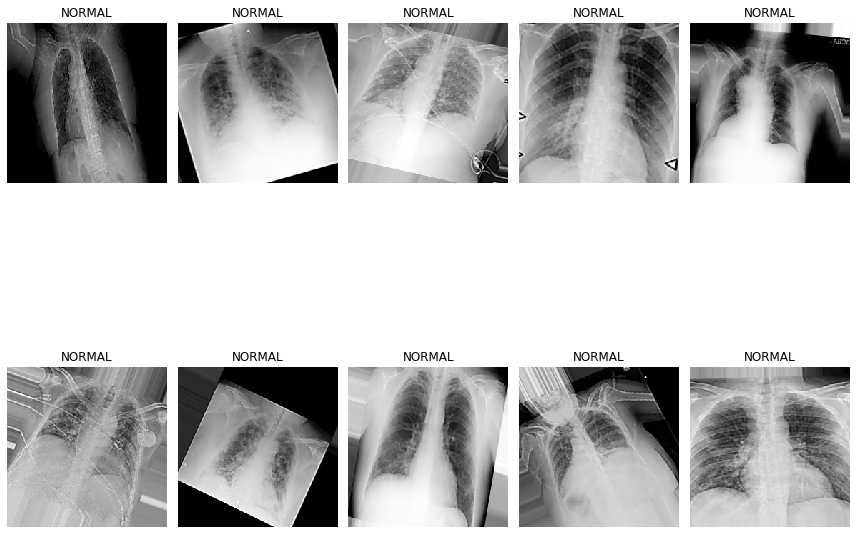

In [4]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:'COVID'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

**DenseNet121**

In [5]:
img_height = 64
img_width = 64
batch_size = 16
train_datagen = ImageDataGenerator(validation_split=0.2) # set validation split

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    classes = ['normal','covid'],
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    classes = ['normal','covid'],
    subset='validation')


test_generator = test_datagen.flow_from_directory(
    test_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    classes = ['normal','covid'],
    shuffle=False,
    class_mode='binary')

Found 2105 images belonging to 2 classes.
Found 525 images belonging to 2 classes.
Found 1030 images belonging to 2 classes.


In [6]:
validation_generator.class_indices

{'normal': 0, 'covid': 1}

In [7]:
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras import layers, metrics
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import Adam
def get_model(res, verbose=0):
    base_model = DenseNet121(input_shape=(res, res, 3),include_top=False,weights='imagenet',pooling='avg')
    x = base_model.output
    x = layers.Dense(1024, activation="relu")(x)
    output = layers.Dense(1, activation="sigmoid")(x)
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-4),loss='binary_crossentropy',metrics=[metrics.AUC(name='auc')])
    if verbose: print(model.summary())
    return model

In [8]:
from collections import Counter
def get_class_weights(train_gen):
    counter = Counter(train_gen.classes)                          
    max_val = float(max(counter.values()))       
    class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}           
    print(f'class_weights {class_weights}')
    return class_weights

In [9]:
def train_model(train_gen, val_gen, model, class_weights, epochs):
    es_cb = callbacks.EarlyStopping(monitor='val_loss',patience=2,min_delta=0.001)
    lr_cb = callbacks.ReduceLROnPlateau(patience=1,min_delta=.05)

    history = model.fit(
        train_gen
        ,epochs=epochs
        ,validation_data=val_gen
        ,callbacks=[es_cb, lr_cb]
        ,class_weight=class_weights)

In [10]:
import numpy as np
from sklearn.metrics import roc_auc_score
def test_model(model, test_gen):
    y_pred_prob = model.predict(test_gen)
    y_true = test_gen.classes
    auc_score = roc_auc_score(y_true, y_pred_prob)
    print(f'auc_score {auc_score}')
    
res = 64
model_densenet121 = get_model(res, verbose=0)
class_weights = get_class_weights(train_generator)

class_weights {0: 115.94444444444444, 1: 1.0}


In [11]:
#train_model(train_generator, validation_generator, model_densenet121, class_weights, epochs=5)
ex_model_densenet121 = model_densenet121.fit(train_generator,epochs=5)

Epoch 1/5
132/132 [==============================] - 254s 2s/step - loss: 0.1233 - auc: 0.4444
Epoch 2/5
132/132 [==============================] - 210s 2s/step - loss: 0.0333 - auc: 0.8483
Epoch 3/5
132/132 [==============================] - 210s 2s/step - loss: 0.0118 - auc: 0.9917
Epoch 4/5
132/132 [==============================] - 214s 2s/step - loss: 0.0093 - auc: 0.8782
Epoch 5/5
132/132 [==============================] - 216s 2s/step - loss: 0.0084 - auc: 0.9485


In [12]:
test_model(model_densenet121, test_generator)

auc_score 0.9052804834054834


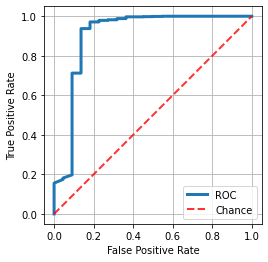

In [14]:

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
def plot_roc(model, test_gen):
    y_pred_prob = model_densenet121.predict(test_gen)
    y_true = test_gen.classes

    fp, tp, _ = roc_curve(y_true, y_pred_prob)

    plt.plot(fp, tp, label='ROC', linewidth=3)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot(
      [0, 1], [0, 1], 
      linestyle='--', 
      linewidth=2, 
      color='r',
      label='Chance', 
      alpha=.8
    )
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.legend(loc="lower right")
    

plot_roc(model_densenet121, test_generator)

y_pred_prob = model_densenet121.predict(test_generator)
y_true = test_generator.classes
fp, tp, tr = roc_curve(y_true, y_pred_prob)
diff = tp - fp
thr = tr[np.argmax(diff)]

[Text(0, 0.5, 'NORMAL'), Text(0, 1.5, 'COVID')]

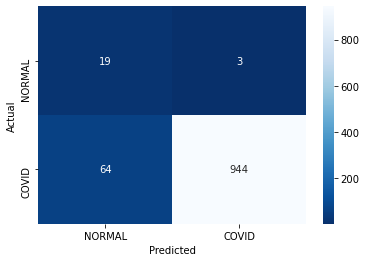

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
tick_labels = ['NORMAL', 'COVID']
predicted_vals = model_densenet121.predict(test_generator)
cm = confusion_matrix(test_generator.labels, predicted_vals > thr)
ax = sns.heatmap(cm, annot=True, fmt="d",cmap="Blues_r")
plt.ylabel('Actual')
plt.xlabel('Predicted')
ax.set_xticklabels(tick_labels)
ax.set_yticklabels(tick_labels)